In [134]:
#spark sql imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
from pyspark.sql import HiveContext
from pyspark.sql.functions import unix_timestamp, col
from pyspark.sql import types
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import seaborn as sns

In [135]:
#spark ML imports
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer, CountVectorizer, IDF
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [136]:
spark = SparkSession.builder.appName('HW3').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 
'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
#spark.sparkContext.getConf().getAll()

In [137]:
sc = spark.sparkContext
hive_context = HiveContext(sc)

1) Read the chicago_crimes Hive table into PySpark (15)

In [138]:
df = hive_context.read.table('renjiel.chicago_crimes')
#df = spark.sql('SELECT * FROM renjiel.chicago_crimes')

a. Print basic summary statistics of the data set

In [139]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- case_number: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: string (nullable = true)
 |-- district: string (nullable = true)
 |-- ward: integer (nullable = true)
 |-- community_area: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: float (nullable = true)
 |-- y_coordinate: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- updated_on: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- location: string (nullable = true)
 |-- location_address: string (nullable = true)
 |-- location_city: string (nullable = true)
 |-- locatio

In [140]:
#df.summary().show()

b. Drop the columns beat, ward, latitude and longitude columns

In [141]:
df= df.drop("beat","ward","latitude","longitude")

In [142]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- case_number: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- district: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: float (nullable = true)
 |-- y_coordinate: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- updated_on: string (nullable = true)
 |-- location: string (nullable = true)
 |-- location_address: string (nullable = true)
 |-- location_city: string (nullable = true)
 |-- location_state: string (nullable = true)
 |-- location_zip: string (nullable = true)



c. Convert remaining columns to appropriate data types. Make your best assumptions by sampling the data. View schema again to ensure that data types have been converted.

In [143]:
df.head(2)

[Row(id=None, case_number='Case Number', dates='Date', block='Block', iucr='IUCR', primary_type='Primary Type', description='Description', location_description='Location Description', arrest=None, domestic=None, district='District', community_area='Community Area', fbi_code='FBI Code', x_coordinate=None, y_coordinate=None, year=None, updated_on='Updated On', location='Location', location_address=None, location_city=None, location_state=None, location_zip=None),
 Row(id=10224738, case_number='HY411648', dates='09/05/2015 01:30:00 PM', block='043XX S WOOD ST', iucr='0486', primary_type='BATTERY', description='DOMESTIC BATTERY SIMPLE', location_description='RESIDENCE', arrest=False, domestic=True, district='009', community_area='61', fbi_code='08B', x_coordinate=1165074.0, y_coordinate=1875917.0, year=2015, updated_on='02/10/2018 03:50:01 PM', location='"(41.815117282', location_address=' -87.669999562)"', location_city=None, location_state=None, location_zip=None)]

In [144]:
df = df.withColumn("dates", unix_timestamp("dates", "MM/dd/yyyy hh:mm:ss aa"))
df = df.withColumn("dates", df.dates.cast(types.TimestampType()))
df = df.withColumn("updated_on", unix_timestamp("updated_on", "MM/dd/yyyy hh:mm:ss aa"))
df = df.withColumn("updated_on", df.updated_on.cast(types.TimestampType()))

In [145]:
df = df.selectExpr("cast(id as int)",
    "cast(case_number as string)",
    "cast(dates as timestamp)",
    "cast(block as string)",
    "cast(iucr as string)",
    "cast(primary_type as string)",
    "cast(description as string)",
    "cast(location_description as string)", 
    "cast(arrest as boolean)",
    "cast(domestic as boolean)",             
    "cast(district as string)",             
    "cast(community_area as string)",                
    "cast(fbi_code as string)",               
    "cast(x_coordinate as float)",              
    "cast(y_coordinate as float)",
                   "cast(year as int)",
                   "cast(updated_on as timestamp)",
                   "cast(location as string)",
                   "cast(location_address as string)",
                   "cast(location_city as string)",
                   "cast(location_state as string)",
                   "cast(location_zip as string)"
                  )

In [146]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- case_number: string (nullable = true)
 |-- dates: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- district: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: float (nullable = true)
 |-- y_coordinate: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- location: string (nullable = true)
 |-- location_address: string (nullable = true)
 |-- location_city: string (nullable = true)
 |-- location_state: string (nullable = true)
 |-- location_zip: string (nullable = true)



d. Add a month column and community name (from metadata) to the dataset

In [147]:
df2 = spark.read.csv("/user/renjiel/names.csv",inferSchema=True, header=True )

In [148]:
df2.head(2)

[Row(ID=1, NAME='Rogers Park'), Row(ID=2, NAME='West Ridge')]

In [149]:
df2.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- NAME: string (nullable = true)



In [150]:
from pyspark.sql.functions import month
df = df.withColumn("month", month("dates"))
df.show(3)

+--------+-----------+-------------------+-------------------+----+------------+--------------------+--------------------+------+--------+--------+--------------+--------+------------+------------+----+-------------------+--------------+----------------+-------------+--------------+------------+-----+
|      id|case_number|              dates|              block|iucr|primary_type|         description|location_description|arrest|domestic|district|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|      location|location_address|location_city|location_state|location_zip|month|
+--------+-----------+-------------------+-------------------+----+------------+--------------------+--------------------+------+--------+--------+--------------+--------+------------+------------+----+-------------------+--------------+----------------+-------------+--------------+------------+-----+
|    null|Case Number|               null|              Block|IUCR|Primary Type|         De

In [151]:
df.createOrReplaceTempView("df")
df2.createOrReplaceTempView("df2")
df3 = spark.sql("select df.*,df2.name from df join df2 on df.community_area = df2.id")
df3.createOrReplaceTempView("df3")
df3.show(3)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+--------+--------------+--------+------------+------------+----+-------------------+--------------+----------------+-------------+--------------+------------+-----+--------+
|      id|case_number|              dates|               block|iucr|primary_type|         description|location_description|arrest|domestic|district|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|      location|location_address|location_city|location_state|location_zip|month|    name|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+--------+--------------+--------+------------+------------+----+-------------------+--------------+----------------+-------------+--------------+------------+-----+--------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD S

2) Explore data by crime attributes (15)

a. Group and count crimes where description begins with the word “aggravated”

In [152]:
spark.sql('''select primary_type,
count(*) as counts from df3 where description like "AGGRAVATED%" group by primary_type''').show()

+--------------------+------+
|        primary_type|counts|
+--------------------+------+
|OFFENSE INVOLVING...|  1451|
|CRIMINAL SEXUAL A...|   856|
|            STALKING|   127|
|               ARSON|  1775|
|             ASSAULT|114269|
|             BATTERY|176298|
|             ROBBERY| 23750|
| CRIM SEXUAL ASSAULT|  6822|
|  DECEPTIVE PRACTICE|   945|
|         SEX OFFENSE|   455|
|          KIDNAPPING|   351|
+--------------------+------+



b. Which crime type is the most prevalent in apartments and which community has it occurred the most

In [153]:
spark.sql("""select primary_type,count(*) from df3
          where location_description = 'APARTMENT' 
          group by primary_type
          order by 2 desc limit 1 """).show()

+------------+--------+
|primary_type|count(1)|
+------------+--------+
|     BATTERY|  265086|
+------------+--------+



In [154]:
spark.sql("""select name,count(*) counts from df3
           where Primary_Type = 'BATTERY' 
           group by name 
           order by counts desc limit 1""").show()

+------+------+
|  name|counts|
+------+------+
|Austin| 87192|
+------+------+



c. What is the maximum number of weapons violations per month that occurred in 2020.

In [155]:
spark.sql('''select `month`, count(*) as counts from df3 where primary_type = "WEAPONS VIOLATION"
and year(dates) = '2020' 
group by 1
order by counts desc limit 1''').show()

+-----+------+
|month|counts|
+-----+------+
|    8|   983|
+-----+------+



d. What percentage of the domestic crimes led to an arrest ?

In [156]:
spark.sql('''select 100*sum(case when arrest = 'true' then 1 else 0 end )/ count(*)
from df3 where domestic = 'true' ''').show()

+------------------------------------------------------------------------------------------------------------------------------------------------------+
|(CAST((CAST(100 AS BIGINT) * sum(CAST(CASE WHEN (arrest = CAST(true AS BOOLEAN)) THEN 1 ELSE 0 END AS BIGINT))) AS DOUBLE) / CAST(count(1) AS DOUBLE))|
+------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                     19.07988752132024|
+------------------------------------------------------------------------------------------------------------------------------------------------------+



3) Explore data by date and time (15)

a. Which day of the week and which month have the most and the least crimes on average

In [157]:
df3.groupBy('Month').count().sort("count").show()

+-----+------+
|Month| count|
+-----+------+
| null|   230|
|    2|450128|
|   12|507180|
|    1|512894|
|   11|532685|
|    3|536923|
|    4|544818|
|   10|603638|
|    9|604981|
|    6|619373|
|    5|622248|
|    8|643880|
|    7|650132|
+-----+------+



In [158]:
df_crimes = df3.withColumn('Day_of_Week',dayofweek(df3.dates))

In [159]:
df_crimes.groupBy('Day_of_week').count().sort("count").show()

+-----------+-------+
|Day_of_week|  count|
+-----------+-------+
|       null|    230|
|          1| 927104|
|          2| 964085|
|          5| 973430|
|          7| 975664|
|          3| 977491|
|          4| 983328|
|          6|1027778|
+-----------+-------+



b. Which date had the most number of homicides in the dataset. How many days passed between this date
and the next highest number of homicides

In [160]:
df_crimes = df3.withColumn('Day',to_date('dates'))
df_crimes.filter(df_crimes.primary_type=='HOMICIDE').groupBy('Day').count().sort(desc("count")).show()

+----------+-----+
|       Day|count|
+----------+-----+
|2020-05-31|   19|
|2015-09-02|   10|
|2003-07-05|   10|
|2020-07-04|    9|
|2021-06-15|    9|
|2016-02-04|    9|
|2016-09-05|    9|
|2018-08-05|    8|
|2017-07-05|    8|
|2020-06-28|    8|
|2020-05-30|    8|
|2020-04-07|    8|
|2004-08-01|    8|
|2017-07-14|    8|
|2016-08-23|    8|
|2021-04-04|    8|
|2017-03-30|    8|
|2016-08-08|    8|
|2017-06-18|    8|
|2021-09-27|    8|
+----------+-----+
only showing top 20 rows



In [161]:
spark.sql("""SELECT DATEDIFF('2020-07-05','2020-05-31') as diff""").show()

+----+
|diff|
+----+
|  35|
+----+



c. Plot a monthly time series line chart of all crimes for the last 3 years

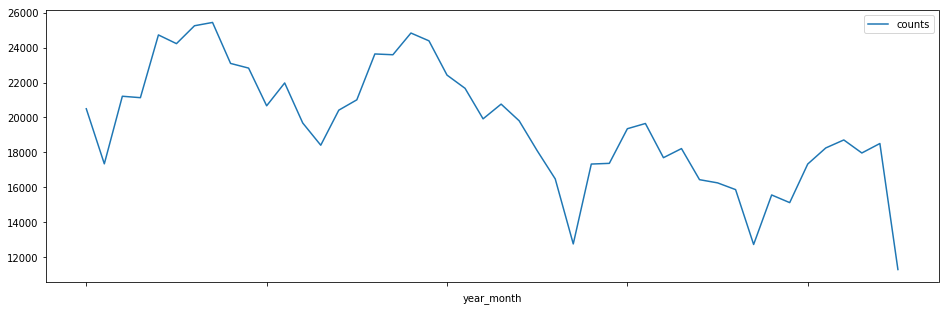

In [162]:
p1 = spark.sql('''select left(dates,7) as year_month,count(*) as counts from df3 
where year(dates) between '2018' and '2021' group by left(dates,7)
order by 1 asc''')
p1.toPandas().plot(y='counts' , x ='year_month', kind='line', figsize=(16,5), rot=0)

d. Plot a year over year comparison for 3 years (2018, 2019, 2020) by top 5 crime types.

In [163]:
top5 = ['THEFT','BATTERY','CRIMINAL DAMAGE','NARCOTICS','ASSAULT']
yearly = df_crimes.filter((df_crimes.year>=2018) 
                 & (df_crimes.year<=2020) 
                 & (df_crimes.primary_type.isin(top5))).groupBy('year','primary_type').count().sort(desc('count')).toPandas()

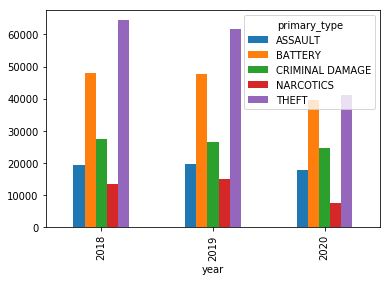

In [164]:
yearly.pivot(index='year',columns='primary_type',values='count').plot(kind='bar')

4) Explore by location (15) Hint: Use spark window functions

a. Use a window function to calculate the community rank based on total crime figures (highest to lowest),
where the community with the highest crime will have rank 1. Your results set should have 1 row for
each community, with a column for the community name and the rank. You can also add a column with
the total crime count if it helps you.

In [165]:
df4 = df3.groupBy('name').count().sort(desc("count"))
df4.show(5)

+---------------+------+
|           name| count|
+---------------+------+
|         Austin|432201|
|Near North Side|251062|
|    South Shore|217228|
|  Humboldt Park|208490|
|      West Town|196389|
+---------------+------+
only showing top 5 rows



In [166]:
df4.withColumn("rank",rank().over(Window.orderBy(desc("count")))).show()

+--------------------+------+----+
|                name| count|rank|
+--------------------+------+----+
|              Austin|432201|   1|
|     Near North Side|251062|   2|
|         South Shore|217228|   3|
|       Humboldt Park|208490|   4|
|           West Town|196389|   5|
|      Near West Side|195382|   6|
|      North Lawndale|194580|   7|
|      West Englewood|193412|   8|
|      Auburn Gresham|187320|   9|
|           Englewood|173361|  10|
|            Roseland|172766|  11|
|Greater Grand Cro...|164066|  12|
|        Chicago Lawn|163676|  13|
|                Loop|163072|  14|
|        Logan Square|153066|  15|
|            Lakeview|147460|  16|
|             Chatham|145002|  17|
|            New City|134393|  18|
|      Belmont Cragin|127153|  19|
|  West Garfield Park|127061|  20|
+--------------------+------+----+
only showing top 20 rows



b. Use a window function to calculate a rolling 7 day sum of crimes over time within each community Your
results set should have 3 columns: community, date, and the rolling/lagging 7 day sum.

In [167]:
df3.show(2)

+--------+-----------+-------------------+-------------------+----+------------+--------------------+--------------------+------+--------+--------+--------------+--------+------------+------------+----+-------------------+--------------+----------------+-------------+--------------+------------+-----+--------+
|      id|case_number|              dates|              block|iucr|primary_type|         description|location_description|arrest|domestic|district|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|      location|location_address|location_city|location_state|location_zip|month|    name|
+--------+-----------+-------------------+-------------------+----+------------+--------------------+--------------------+------+--------+--------+--------------+--------+------------+------------+----+-------------------+--------------+----------------+-------------+--------------+------------+-----+--------+
|10224738|   HY411648|2015-09-05 13:30:00|    043XX S WOOD ST|04

In [173]:
df_day = df3.withColumn("dates",to_date("dates"))
df_day = df_day.groupBy('name','dates').count().dropna()
df_day.show(20)

+---------------+----------+-----+
|           name|     dates|count|
+---------------+----------+-----+
| South Lawndale|2014-12-08|   12|
|     West Ridge|2001-03-08|    7|
|       Lakeview|2001-03-08|    8|
|    Fuller Park|2019-10-25|    3|
|    Rogers Park|2015-03-21|    9|
| Belmont Cragin|2001-03-18|    1|
|   North Center|2019-10-27|    1|
|      West Lawn|2015-06-15|    6|
|   Lincoln Park|2001-06-11|    1|
|Grand Boulevard|2018-02-11|    8|
|     Bridgeport|2020-12-14|    6|
|   Norwood Park|2015-04-03|    3|
|    Morgan Park|2015-04-09|    8|
|   Lincoln Park|2001-07-01|    3|
|   Norwood Park|2001-04-27|    2|
|Near North Side|2001-04-25|    3|
|    Rogers Park|2001-05-24|    4|
|  Humboldt Park|2015-06-29|   19|
|    Forest Glen|2001-08-09|    2|
|   Lincoln Park|2001-08-11|    1|
+---------------+----------+-----+
only showing top 20 rows



In [174]:
CumSum = Window.partitionBy('name').orderBy("dates").rowsBetween(-6,0)
df5 = df_day.withColumn("cum_sum",sum('count').over(CumSum))

In [175]:
df5.select('name','Dates','cum_sum').show()

+----------+----------+-------+
|      name|     Dates|cum_sum|
+----------+----------+-------+
|North Park|2001-01-01|      2|
|North Park|2001-01-05|      3|
|North Park|2001-01-24|      4|
|North Park|2001-03-22|      5|
|North Park|2001-08-19|      6|
|North Park|2001-09-01|      7|
|North Park|2001-10-01|      8|
|North Park|2001-10-09|      7|
|North Park|2001-10-11|      7|
|North Park|2001-11-02|      7|
|North Park|2001-11-16|      7|
|North Park|2001-12-01|      8|
|North Park|2001-12-04|      8|
|North Park|2001-12-09|      8|
|North Park|2001-12-18|      8|
|North Park|2001-12-29|      9|
|North Park|2002-01-20|      9|
|North Park|2002-01-25|      9|
|North Park|2002-02-01|      8|
|North Park|2002-02-19|      8|
+----------+----------+-------+
only showing top 20 rows



c. Use window functions to calculate a 7 day moving average and cumulative sum of crimes over
time within each community. Your results set should have 4 columns: community, date, the 7 day
moving average, and the cumulative sum.

In [176]:
df_day.show(5)

+--------------+----------+-----+
|          name|     dates|count|
+--------------+----------+-----+
|South Lawndale|2014-12-08|   12|
|    West Ridge|2001-03-08|    7|
|      Lakeview|2001-03-08|    8|
|   Fuller Park|2019-10-25|    3|
|   Rogers Park|2015-03-21|    9|
+--------------+----------+-----+
only showing top 5 rows



In [177]:
cs = Window.partitionBy('name').orderBy("dates").rowsBetween(-6,0)
ma = Window.partitionBy('name').orderBy("dates").rowsBetween(-3,3)

df5 = df_day.withColumn("moving_avg",avg("count").over(ma))\
.withColumn("cum_sum",sum('count').over(cs))

In [178]:
df5.show(10)

+----------+----------+-----+------------------+-------+
|      name|     dates|count|        moving_avg|cum_sum|
+----------+----------+-----+------------------+-------+
|North Park|2001-01-01|    2|              1.25|      2|
|North Park|2001-01-05|    1|               1.2|      3|
|North Park|2001-01-24|    1|1.1666666666666667|      4|
|North Park|2001-03-22|    1|1.1428571428571428|      5|
|North Park|2001-08-19|    1|               1.0|      6|
|North Park|2001-09-01|    1|               1.0|      7|
|North Park|2001-10-01|    1|               1.0|      8|
|North Park|2001-10-09|    1|               1.0|      7|
|North Park|2001-10-11|    1|1.1428571428571428|      7|
|North Park|2001-11-02|    1|1.1428571428571428|      7|
+----------+----------+-----+------------------+-------+
only showing top 10 rows



d. Cross-tabulate Crime Types vs Location description and visualize it through a heatmap

In [179]:
df_4d = df3.drop("location_city","location_state","location_zip")

In [180]:
df_4d = df_4d.dropna()

In [181]:
p1 = df_4d.groupBy('primary_type').pivot('description').count().toPandas().fillna(0)

In [182]:
p1.set_index('primary_type',inplace=True)

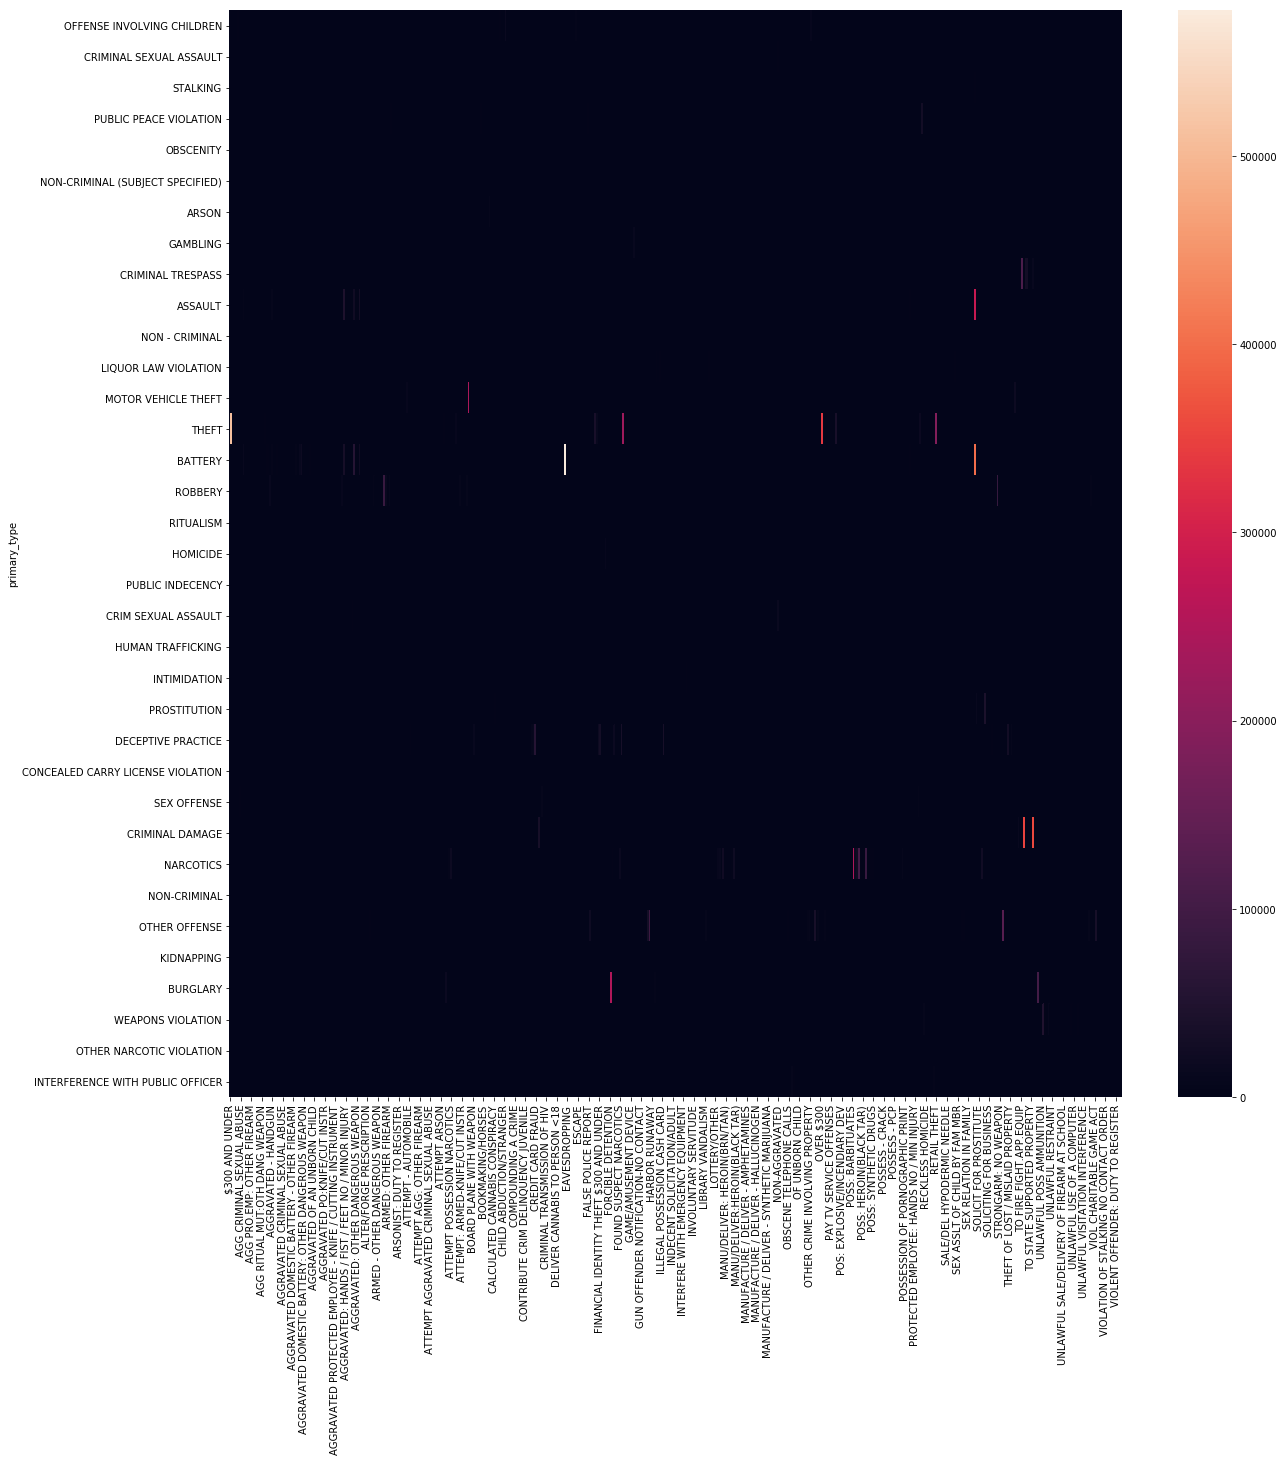

In [183]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(p1,ax=ax)

5) Impact of Covid-19 (40)

a. Bring in daily Covid cases data from the City of Chicago data portal and load into a table chicago_covid
in your RCC Hive database.

In [184]:
covid = hive_context.read.table('renjiel.chicago_covid4')
covid.show(5)

+----------+----------+-----------+---------------------+
|     dates|case_total|death_total|hospitalization_total|
+----------+----------+-----------+---------------------+
|      Date|      null|       null|                 null|
|2020-03-01|         0|          0|                    2|
|2020-03-02|         0|          0|                    1|
|2020-03-03|         0|          0|                    3|
|2020-03-04|         0|          0|                    2|
+----------+----------+-----------+---------------------+
only showing top 5 rows



b. Create summarized daily total counts of the daily crime data by crime type

In [185]:
sum1 = spark.sql("""select date(dates),primary_type,count(*) as counts from df3
group by 1,2
order by 1,2""")
sum1.dropna().show()

+----------+--------------------+------+
|     dates|        primary_type|counts|
+----------+--------------------+------+
|2001-01-01|             BATTERY|     4|
|2001-01-01| CRIM SEXUAL ASSAULT|    29|
|2001-01-01|CRIMINAL SEXUAL A...|     3|
|2001-01-01|  DECEPTIVE PRACTICE|    33|
|2001-01-01|            HOMICIDE|     2|
|2001-01-01| MOTOR VEHICLE THEFT|    11|
|2001-01-01|OFFENSE INVOLVING...|    77|
|2001-01-01|       OTHER OFFENSE|     8|
|2001-01-01|         SEX OFFENSE|    56|
|2001-01-01|            STALKING|     1|
|2001-01-01|               THEFT|   145|
|2001-01-02|            BURGLARY|     2|
|2001-01-02|   CRIMINAL TRESPASS|     3|
|2001-01-02|  DECEPTIVE PRACTICE|     2|
|2001-01-02| MOTOR VEHICLE THEFT|     5|
|2001-01-02|       OTHER OFFENSE|     1|
|2001-01-02|         SEX OFFENSE|     1|
|2001-01-02|               THEFT|    11|
|2001-01-03|             BATTERY|     2|
|2001-01-03|            BURGLARY|     1|
+----------+--------------------+------+
only showing top

c. Join daily total covid cases and death data with daily chicago crimes data starting Jan 2020.

In [186]:
sum1.createOrReplaceTempView("sum1")
covid.createOrReplaceTempView("covid")

In [187]:
joined = spark.sql("""select a.dates,primary_type,counts,case_total,death_total,hospitalization_total
from sum1 a join covid b on a.dates = b.dates
order by a.dates""")
joined.show(5)

+----------+--------------------+------+----------+-----------+---------------------+
|     dates|        primary_type|counts|case_total|death_total|hospitalization_total|
+----------+--------------------+------+----------+-----------+---------------------+
|2020-03-01|               ARSON|     1|         0|          0|                    2|
|2020-03-01|             ASSAULT|    46|         0|          0|                    2|
|2020-03-01|             BATTERY|   142|         0|          0|                    2|
|2020-03-01|            BURGLARY|    15|         0|          0|                    2|
|2020-03-01|CONCEALED CARRY L...|     2|         0|          0|                    2|
+----------+--------------------+------+----------+-----------+---------------------+
only showing top 5 rows



d. Perform a thorough analysis in PySpark on how Covid-19 has impacted various types of crimes
compared to previous years.

In [188]:
joined.select('dates').sort(desc('dates')).show(1)

+----------+
|     dates|
+----------+
|2021-10-19|
+----------+
only showing top 1 row



In [189]:
joined.select('dates').sort(asc('dates')).show(1)

+----------+
|     dates|
+----------+
|2020-03-01|
+----------+
only showing top 1 row



In [190]:
joined.select('case_total').sort(asc('case_total')).show(1)

+----------+
|case_total|
+----------+
|         0|
+----------+
only showing top 1 row



In [191]:
joined.select('case_total').sort(desc('case_total')).show(1)

+----------+
|case_total|
+----------+
|      3355|
+----------+
only showing top 1 row



cimes type count during covid

In [192]:
joined.groupBy('primary_type').agg(sum('counts')).sort(desc('sum(counts)')).show()

+--------------------+-----------+
|        primary_type|sum(counts)|
+--------------------+-----------+
|             BATTERY|      64189|
|               THEFT|      63471|
|     CRIMINAL DAMAGE|      41430|
|             ASSAULT|      31188|
|  DECEPTIVE PRACTICE|      28183|
|       OTHER OFFENSE|      21085|
| MOTOR VEHICLE THEFT|      16566|
|   WEAPONS VIOLATION|      14838|
|             ROBBERY|      12402|
|            BURGLARY|      12272|
|           NARCOTICS|       8477|
|   CRIMINAL TRESPASS|       5753|
|OFFENSE INVOLVING...|       2959|
|CRIMINAL SEXUAL A...|       2092|
|         SEX OFFENSE|       1585|
|PUBLIC PEACE VIOL...|       1565|
|            HOMICIDE|       1379|
|               ARSON|        951|
|INTERFERENCE WITH...|        671|
|            STALKING|        450|
+--------------------+-----------+
only showing top 20 rows



crimes for the same time frame last year 

In [193]:
df3 = df3.withColumn('dates',to_date('dates'))
df3.createOrReplaceTempView("df3")
df3 = spark.sql("""select * from df3 where
dates >= '2018-07-13' and dates <= '2020-03-01'""")
df3.show(2)

+--------+-----------+----------+--------------------+----+------------------+--------------------+--------------------+------+--------+--------+--------------+--------+------------+------------+----+-------------------+--------------+----------------+-------------+--------------+------------+-----+---------------+
|      id|case_number|     dates|               block|iucr|      primary_type|         description|location_description|arrest|domestic|district|community_area|fbi_code|x_coordinate|y_coordinate|year|         updated_on|      location|location_address|location_city|location_state|location_zip|month|           name|
+--------+-----------+----------+--------------------+----+------------------+--------------------+--------------------+------+--------+--------+--------------+--------+------------+------------+----+-------------------+--------------+----------------+-------------+--------------+------------+-----+---------------+
|11646166|   JC213529|2018-09-01|082XX S INGLESID

In [194]:
df3.groupBy('primary_type').count().sort(desc('count')).show()

+--------------------+------+
|        primary_type| count|
+--------------------+------+
|               THEFT|104015|
|             BATTERY| 80254|
|     CRIMINAL DAMAGE| 43633|
|             ASSAULT| 33226|
|  DECEPTIVE PRACTICE| 30920|
|       OTHER OFFENSE| 27416|
|           NARCOTICS| 23900|
|            BURGLARY| 16836|
| MOTOR VEHICLE THEFT| 15210|
|             ROBBERY| 14070|
|   CRIMINAL TRESPASS| 11132|
|   WEAPONS VIOLATION|  9985|
|OFFENSE INVOLVING...|  3825|
|INTERFERENCE WITH...|  2389|
|PUBLIC PEACE VIOL...|  2375|
|         SEX OFFENSE|  2123|
| CRIM SEXUAL ASSAULT|  1685|
|        PROSTITUTION|  1101|
|CRIMINAL SEXUAL A...|  1053|
|            HOMICIDE|   885|
+--------------------+------+
only showing top 20 rows



the count for different types of crimes changed during covid, theft is no longer the top cirmes in chicago. The count of battery increased a lot during covid.

In [195]:
joined.filter(joined.primary_type == 'BATTERY').select('dates','case_total','counts').sort(desc('case_total')).show()

+----------+----------+------+
|     dates|case_total|counts|
+----------+----------+------+
|2020-11-10|      3355|    96|
|2020-11-09|      3230|   106|
|2020-11-12|      2928|    83|
|2020-11-06|      2797|   106|
|2020-11-13|      2694|    78|
|2020-11-05|      2639|   106|
|2020-11-16|      2558|    92|
|2020-11-04|      2514|   116|
|2020-11-11|      2490|    80|
|2020-11-17|      2466|    71|
|2020-11-30|      2390|    93|
|2020-11-23|      2377|    88|
|2020-11-18|      2327|    65|
|2020-11-02|      2324|    83|
|2020-11-20|      2302|   117|
|2020-12-01|      2188|    80|
|2020-11-19|      2169|    96|
|2020-11-03|      2144|    99|
|2020-12-03|      2072|    54|
|2020-12-07|      2068|    68|
+----------+----------+------+
only showing top 20 rows



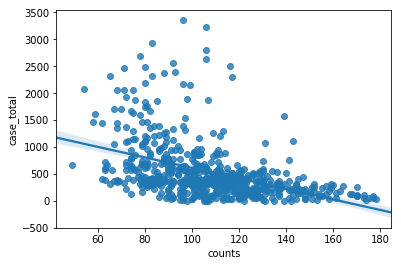

In [196]:
t1 = joined.filter(joined.primary_type == 'BATTERY').select('case_total','counts').toPandas()
sns.regplot(x = t1.counts, y = t1.case_total)

it appears there is a negative relationship between the number of battery counts and the number of total covid cases in chicago for a day

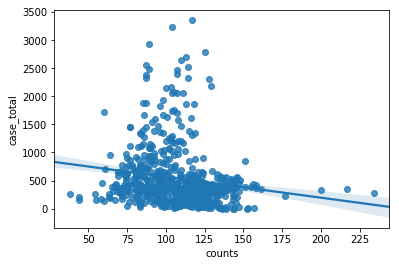

In [197]:
t2 = joined.filter(joined.primary_type == 'THEFT').select('case_total','counts').toPandas()
sns.regplot(x = t2.counts, y = t2.case_total)

for theft there also appears to be a negative relationhip

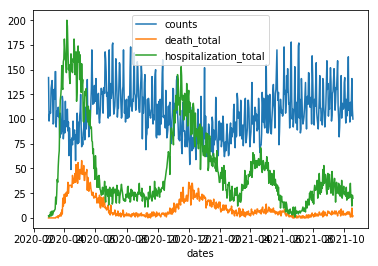

In [198]:
joined.filter(joined.primary_type == 'BATTERY').select('dates','counts','death_total'
                                                      ,'hospitalization_total').toPandas().plot(x = 'dates')

death_total and hospitalization_total follows the same kind of trend, but battery follows the opposite trend because they also have a negative relatiohsion

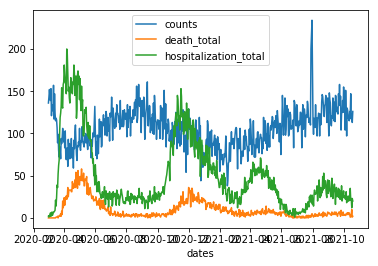

In [199]:
joined.filter(joined.primary_type == 'THEFT').select('dates','counts','death_total'
                                                      ,'hospitalization_total').toPandas().plot(x = 'dates')

Theft follows the same kind of trned as battery, however there appears to be a spike around mid 2021

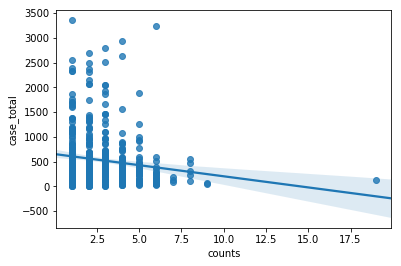

In [200]:
t2 = joined.filter(joined.primary_type == 'HOMICIDE').select('case_total','counts').toPandas()
sns.regplot(x = t2.counts, y = t2.case_total)

homicide has a very tiny negative relationship with total cases

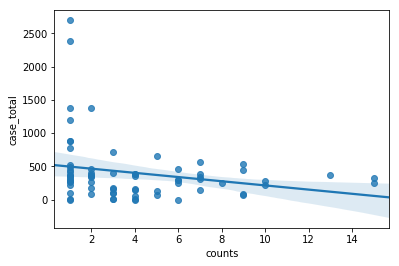

In [201]:
t2 = joined.filter(joined.primary_type == 'PROSTITUTION').select('case_total','counts').toPandas()
sns.regplot(x = t2.counts, y = t2.case_total)

PROSTITUTION also has a very negative relationship

In [202]:
top5 = ['THEFT','BATTERY','CRIMINAL DAMAGE','NARCOTICS','ASSAULT']
yearly = joined.filter(joined.primary_type.isin(top5)).groupBy(month('dates'),'primary_type').agg(sum('counts')).toPandas()

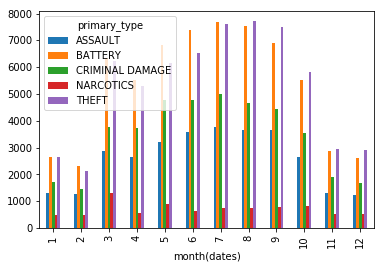

In [203]:
yearly.pivot(index='month(dates)',columns='primary_type',values='sum(counts)').plot(kind='bar')

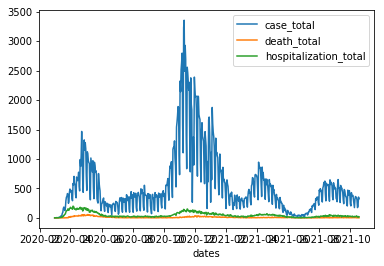

In [204]:
joined.select('dates','case_total','death_total','hospitalization_total').toPandas().plot(x = 'dates')

Cvoid cases spiked during the end of 2020

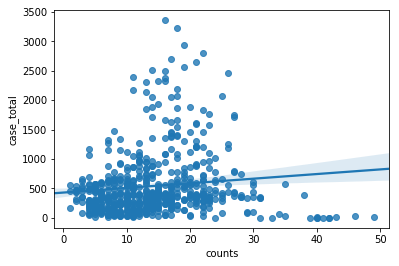

In [205]:
t1 = joined.filter(joined.primary_type == 'NARCOTICS').select('case_total','counts').toPandas()
sns.regplot(x = t1.counts, y = t1.case_total)

not suprisingly narcotics has a positive relationship with the covid cases since it can be done at home

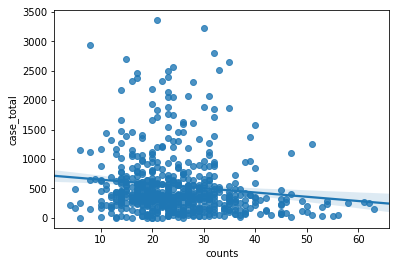

In [206]:
t1 = joined.filter(joined.primary_type == 'WEAPONS VIOLATION').select('case_total','counts').toPandas()
sns.regplot(x = t1.counts, y = t1.case_total)

weapons violation also has a negative relationship with covid cases

In [207]:
top5 = ['THEFT','BATTERY','CRIMINAL DAMAGE','NARCOTICS','ASSAULT']
yearly = joined.filter(joined.primary_type.isin(top5)).groupBy(year('dates'),'primary_type').agg(sum('counts')).toPandas()

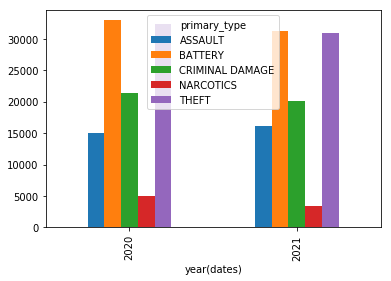

In [208]:
yearly.pivot(index='year(dates)',columns='primary_type',values='sum(counts)').plot(kind='bar')

during covid period the cirms breakdown for different years are similar 